##**Amazon Fine Food Reviews**

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

####**Objective:**

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In [ ]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
! kaggle datasets download -d snap/amazon-fine-food-reviews

 97% 236M/242M [00:01<00:00, 158MB/s]
100% 242M/242M [00:01<00:00, 143MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


###**Import Library**:

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###**Exploratory Data Analysis:**

In [ ]:
con = sqlite3.connect('database.sqlite')

####**Reading Data:**

In [ ]:
df = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)

In [ ]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.shape

In [ ]:
df.columns

####**Rating  distribution across whole dataset:**

In [ ]:
df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

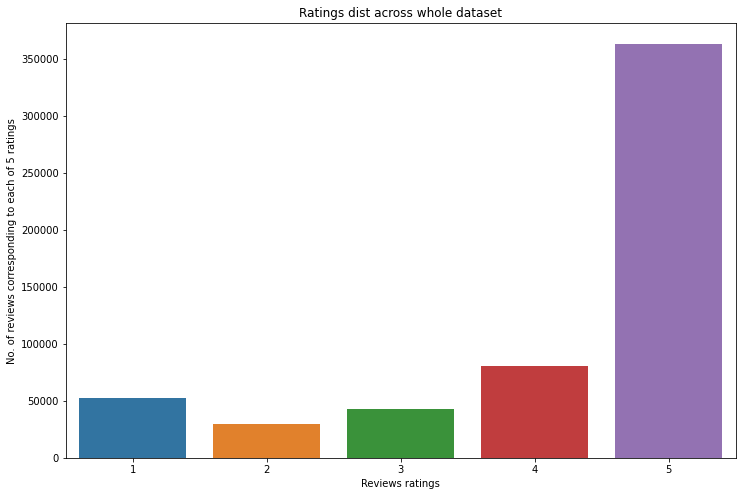

In [ ]:
plt.figure(figsize = (12,8))
ax = sns.countplot(df['Score'])

plt.title('Ratings dist across whole dataset')
plt.xlabel('Reviews ratings')
plt.ylabel("No. of reviews corresponding to each of 5 ratings")
plt.show()

Conclusion
1. Above 350000 reviews are rated 5 stars from the total.
2. Around 90000 reviews are rated 4 stars.
3. Just below 50000 reviews are. rated 3 stars.
4. Slightly above 50000 reviews are rated 1 star.
5. And around 25000 reviews are rated 2 stars.
6. Most of the products are given 5 stars. 

###**Converting into Machine Learning Problem:**

- We are considering all the score which is equals to 3 as neutral, so we are removing them from the dataset.
- Labelling score 4 and 5 as Positive, and score 1 and 2 as Negetive review.
- So, we divided all the data points into two catogery as positive and negative.
- We have a binary class classification problem. 

In [ ]:
filtered_df = pd.read_sql_query('''
SELECT *
FROM Reviews
WHERE Score != 3
''' , con)

In [ ]:
filtered_df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [ ]:
filtered_df['Score'].unique()

array([5, 1, 4, 2])

In [ ]:
filtered_df['Score'] = df['Score'].apply(lambda score:'Negative' if score<3 else 'Positive') 

In [ ]:
filtered_df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


###**Distribution of Filtered Score across dataset:**

In [ ]:
filtered_df['Score'].value_counts()

Positive    449613
Negative     76201
Name: Score, dtype: int64

- Imbalance dataset.

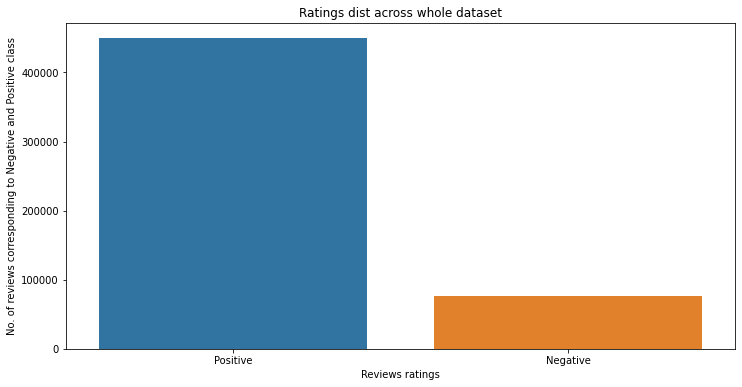

In [ ]:
plt.figure(figsize = (12,6))
ax = sns.countplot(filtered_df['Score'])

plt.title('Ratings dist across whole dataset')
plt.xlabel('Reviews ratings')
plt.ylabel("No. of reviews corresponding to Negative and Positive class")
plt.show()

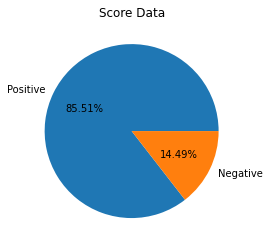

In [ ]:
filtered_df['Score'].value_counts().plot(kind='pie',labels=['Positive','Negative'],autopct='%.2f%%',ylabel='',title='Score Data')

- Data is imbalance.

###**Statistics:**

In [ ]:
filtered_df.describe(exclude = ['object'])

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,525814.000000,525814.000000,525814.000000,5.258140e+05
mean,284599.060038,1.747293,2.209544,1.295943e+09
std,163984.038077,7.575819,8.195329,4.828129e+07
min,1.000000,0.000000,0.000000,9.393408e+08
25%,142730.250000,0.000000,0.000000,1.270598e+09
50%,284989.500000,0.000000,1.000000,1.310861e+09
75%,426446.750000,2.000000,2.000000,1.332634e+09
max,568454.000000,866.000000,878.000000,1.351210e+09


####**HelpfulnessNumerator and HelpfulnessDenominator Visualization:**

In [ ]:
filtered_df['HelpfulnessNumerator'].value_counts().head(10)

- No. of people who find the review helpful.
- HelpfulnessNumerator value is the sum of both the values HelpfulnessNumerator and HelpfulnessDenominator.
- Zero occur most no. of times.
- As the value increase frequency decrease.

In [ ]:
filtered_df['HelpfulnessDenominator'].value_counts().head(10)

0    251629
1    103966
2     56479
3     31487
4     20356
5     13490
6      9503
7      6844
8      4920
9      4075
Name: HelpfulnessDenominator, dtype: int64

- No. of people who doesn't find this review helpful.
- HelpfulnessNumerator value is always greater than helpfulnessDenominator.


In [ ]:
vc = filtered_df['HelpfulnessNumerator'].value_counts().to_frame().reset_index().head(10)
import plotly.express as px

fig = px.bar(x=vc['HelpfulnessNumerator'], y=vc['index'][::-1])

fig.update_layout(title = 'Top 10 HelpfulnessNumerator', xaxis_title="", yaxis_title='Frequency',font_size=18)

In [ ]:
vc = filtered_df['HelpfulnessDenominator'].value_counts().to_frame().reset_index().head(10)
import plotly.express as px

fig = px.bar(x=vc['HelpfulnessDenominator'], y=vc['index'][::-1])

fig.update_layout(title = 'Top 10 HelpfulnessDenominator', xaxis_title="", yaxis_title='Frequency',font_size=18)

####**Sort Data According to "Time" feature:** 

In [ ]:
filtered_df.sort_values(['Time'], ascending=True, inplace=True)
filtered_df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Negative,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...


###**Data Cleaning:**

####**Drop Dublicates:**

- It is observed that the reviews data had many duplicated entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of data.
- HelpfulnessNumerator should always be less than HelpfulnessDenominator.

In [ ]:
final_df=filtered_df.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, keep='first', inplace=False)
final_df.shape

(364173, 10)

In [ ]:
(final_df['Id'].size*1.0)/(filtered_df['Id'].size*1.0)*100

69.25890143662969

1. So, 161,641 duplicates has been removed from the dataset.
2. About 69.25 % of data is remaining after drop duplicates.
3. Product which have the same userid, profile name, time and text are same are considered as duplicates.

In [ ]:
final_df=final_df[final_df.HelpfulnessNumerator<=final_df.HelpfulnessDenominator]

In [ ]:
final_df.shape

(364171, 10)

1. Two rows are removed, we have 2 rows where helpfulnessnumerator is greater than helpfulnessdenominator.

####**Checking for the missing value:**

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 138706 to 386211
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      364171 non-null  int64 
 1   ProductId               364171 non-null  object
 2   UserId                  364171 non-null  object
 3   ProfileName             364171 non-null  object
 4   HelpfulnessNumerator    364171 non-null  int64 
 5   HelpfulnessDenominator  364171 non-null  int64 
 6   Score                   364171 non-null  object
 7   Time                    364171 non-null  int64 
 8   Summary                 364171 non-null  object
 9   Text                    364171 non-null  object
dtypes: int64(4), object(6)
memory usage: 30.6+ MB


- There are no missing value after removing dublicates values.

In [ ]:
final_df['Score'].value_counts()

Positive    311444
Negative     52727
Name: Score, dtype: int64

####**Dropping the unwanted columns from our data frame:**

In [ ]:
final_df.drop("Id", inplace=True, axis=1)
final_df.drop("ProductId", inplace=True, axis=1)
final_df.drop("ProfileName", inplace=True, axis=1)
final_df.drop("HelpfulnessNumerator", inplace=True, axis=1)
final_df.drop("HelpfulnessDenominator", inplace=True, axis=1)
final_df.head()

,UserId,Score,Time,Summary,Text
138706,ACITT7DI6IDDL,Negative,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,AJ46FKXOVC7NR,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,AIUWLEQ1ADEG5,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,A344SMIA5JECGM,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,AJH6LUC1UT1ON,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


#####**Make all 'Score' less than 3 equal to -ve class and 'Score' greater than 3 equal to +ve class.**

In [ ]:
final_df['Score'] = df['Score'].apply(lambda score:'0' if score<3 else '1')

In [ ]:
final_df.head(2)

,UserId,Score,Time,Summary,Text
138706,ACITT7DI6IDDL,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,AJ46FKXOVC7NR,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...


###**Text Pre-processing:**

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

#####**Printing Random Reviews:**

In [ ]:
sent_0 = final_df['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final_df['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_df['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_df['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!<br /><br />If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had. 

#####**Remove HTML:**

In [ ]:
def cleanhtml(sentence):
    cleanr = re.compile("http\S+")
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#####**Punctuation Remove:**

In [ ]:
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]', r' ', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

#####**Pattern Removal:**

In [ ]:
def patternremoval(s):
    a =re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b","",s)
    return a

#####**Decontracted:**

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#####**Stopwords:**

In [ ]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'but', 'did', "wouldn't", "it's", "shouldn't", 'very', 'our', "hadn't", 'because', 'on', 'i', 'it', 'hasn', 'too', "shan't", 'me', 'the', "couldn't", 'we', 'at', 'himself', 've', 'how', 'will', 'about', "won't", 'in', 'theirs', 'him', 'y', 'why', 'once', 'had', 'didn', "you're", 'won', 'that', 'what', "that'll", 'above', "needn't", 'if', 'only', 'such', 'his', 'been', 'you', 'than', 'up', 'while', 'into', 'being', 'ma', 'then', 'before', 'own', 'here', 'she', 'do', 'isn', "aren't", 'having', "haven't", 'against', 'was', 'from', 'weren', 'd', 'over', 'ourselves', 'am', 'with', 'these', 'o', 'aren', "hasn't", 'he', 'between', 'themselves', 'any', 'your', "isn't", 'so', 'by', 'of', "should've", 't', 'to', 'until', 'most', "didn't", "she's", 'their', 'when', 'is', 'as', 'whom', 'wouldn', 'not', 'hers', 'haven', "don't", 'both', 'off', "you've", 'all', 'doesn', 'those', 'should', 'are', 'herself', 'needn', "mightn't", 'myself', 'yours', 'don', 'during', 'under', 'has', 'nor', 'below', "was

In [ ]:
excluded_stopwords = set(['against','very','not','don', "don't",'ain','aren',"aren't",'couldn',"couldn't",'didn', "didn't",'doesn',"doesn't",
                 'hadn',"hadn't", 'hasn', "hasn't",'haven',"haven't",'isn', "isn't",'mightn',"mightn't",'mustn',"mustn't",
                 'needn',"needn't",'shouldn', "shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"])

In [ ]:
required_stopwords = set(stop_words) - set(excluded_stopwords)

In [ ]:
print(required_stopwords)

{'but', 'did', "it's", 'our', 'because', 'on', 'i', 'it', 'too', "shan't", 'me', 'the', 'we', 'at', 'himself', 've', 'how', 'will', 'about', 'in', 'theirs', 'him', 'y', 'why', 'once', 'had', "you're", 'that', 'what', "that'll", 'above', 'if', 'only', 'such', 'his', 'been', 'you', 'than', 'up', 'while', 'into', 'being', 'ma', 'then', 'before', 'own', 'here', 'she', 'do', 'having', 'was', 'from', 'd', 'over', 'ourselves', 'am', 'with', 'these', 'o', 'he', 'between', 'themselves', 'any', 'your', 'so', 'by', 'of', "should've", 't', 'to', 'until', 'most', "she's", 'their', 'when', 'is', 'as', 'whom', 'hers', 'both', 'off', "you've", 'all', 'those', 'should', 'are', 'herself', 'myself', 'yours', 'during', 'under', 'has', 'nor', 'below', 'through', 'shan', 'll', 'have', 'where', 'more', 'out', "you'll", 'or', 'no', 'can', 'and', 'other', 'yourselves', 'which', 'now', 'itself', 'just', 'further', 'some', 'this', 'few', 'who', 'they', 'same', 'm', 'her', 'an', 'be', 'down', 'doing', 'there', 's

In [ ]:
from bs4 import BeautifulSoup

####**Pre-process Summary:**

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final_df['Text'].values):
    sentance = cleanhtml(sentance)
    sentance = cleanpunc(sentance)
    sentance = patternremoval(sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in required_stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:17<00:00, 1844.17it/s]


In [ ]:
preprocessed_reviews[1500]

'bought tea seattle dying get really best tea ever great hot cold'

###**Featurization:**

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(width=1200,height=500,min_font_size=10,background_color='white')

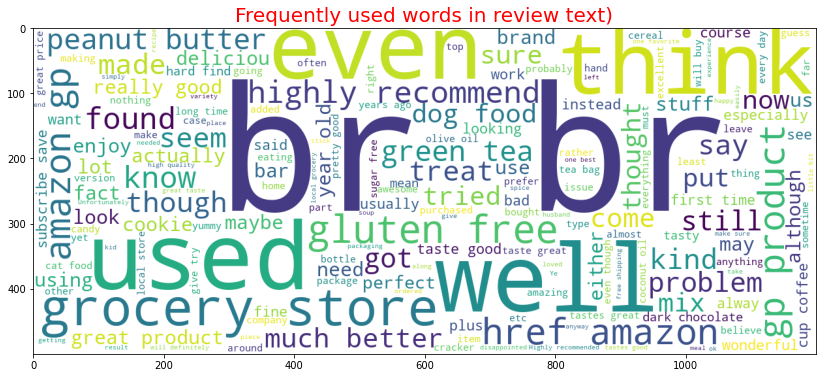

In [ ]:
Text = wc.generate(final_df['Text'].str.cat(sep=' ')) # object of words

plt.figure(figsize=(15,6))
plt.imshow(Text)
plt.title('Frequently used words in review text)',fontdict={'fontsize':20},loc='center',color='r')
plt.show()

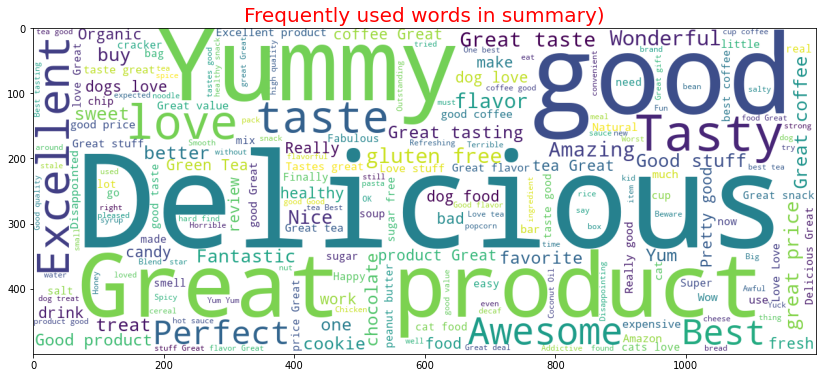

In [ ]:
Summary = wc.generate(final_df['Summary'].str.cat(sep=' ')) # object of words

plt.figure(figsize=(15,6))
plt.imshow(Summary)
plt.title('Frequently used words in summary)',fontdict={'fontsize':20},loc='center',color='r')
plt.show()

###**Stemming:**

#####**Snowball Stemmer:**

In [ ]:
sno = nltk.SnowballStemmer('english')

In [ ]:
def stemming(tokenized_text):
  text ="".join([sno.stem(word) for word in tokenized_text])
  return text

In [ ]:
final_df['Stemming_Text'] = final_df['Text'].apply(stemming)
final_df.head(2)

,UserId,Score,Time,Summary,Text,Stemming_Text
138706,ACITT7DI6IDDL,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,this witty little book makes my son laugh at l...
138683,AJ46FKXOVC7NR,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,i can remember seeing the show when it aired o...


###**Modelling:**

####**TF-IDF Vectorizer:**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [ ]:
X = tfidf.fit_transform(preprocessed_reviews).toarray()
y = final_df['Score'].values

#####**Multinomial Naive Bayes and Bernoulli Naive Bayes model:**

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [ ]:
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score

In [ ]:
mb = MultinomialNB()
bb = BernoulliNB()

In [ ]:
mb.fit(X_train,y_train)
mb_pred = mb.predict(X_test)
accuracy_score(y_test,mb_pred)
print(accuracy_score(y_test,mb_pred))
print(confusion_matrix(y_test,mb_pred))
print(precision_score(y_test,mb_pred))

In [ ]:
bb.fit(X_train,y_train)
bb_pred = bb.predict(X_test)
accuracy_score(y_test,bb_pred)
print(accuracy_score(y_test,bb_pred))
print(confusion_matrix(y_test,bb_pred))
print(precision_score(y_test,bb_pred))